## Imports

In [1]:
from PW_explorer.run_dlv import run_dlv
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.export import PWEExport
from PW_explorer.pwe_helper import pw_slicer, rel_slicer
import pandas as pd
import numpy as np
import PW_explorer

## User-defined Visualization Function

In [2]:
# Define a simple visualization function to show-off our results
import networkx as nx
import nxpd
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
def visualize_game(moves_df, win_df, drawn_df, lost_df):
    G = nx.DiGraph()
    G.add_edges_from(list(zip(list(moves_df['x1']), list(moves_df['x2']))))
    for node in G.nodes:
        G.nodes[node]['style'] = 'filled'
        G.nodes[node]['fontname'] = 'Helvetica'
        G.nodes[node]['color'] = 'black'
        G.node[node]['fillcolor'] = 'white'
    if win_df is not None:
        for node in list(win_df['x1']): G.nodes[node]['fillcolor'] = '#80FF80'
    if drawn_df is not None:
        for node in list(drawn_df['x1']): G.nodes[node]['fillcolor'] = '#FFFF80'
    if lost_df is not None:
        for node in list(lost_df['x1']): G.nodes[node]['fillcolor'] = '#FF8080'
    return G

## Game encoding

Rules for a complicated game.

A state is a winning state if there exists a move that takes it to a state that is not a winning state.

In [3]:
dlv_rules = [
    'move(a,b). move(a,c). move(k,l).',
    'move(c,d). move(c,e). move(l,e). move(l,m).',
    'move(d,e). move(e,d). move(e,m). move(m,e).',
    'move(d,f). move(d,g). move(g,d). move(e,h). move(m,n). move(n,m).',
    'win(X) :- move(X,Y), not win(Y).',
]

Using DLV, we get the following PWs (2-valued models):

In [4]:
dlv_soln, meta_data = run_dlv(dlv_rules=dlv_rules)
print('\n'.join(dlv_soln))

{move(a,b), move(a,c), move(c,d), move(c,e), move(k,l), move(l,e), move(l,m), move(d,e), move(d,f), move(d,g), move(e,d), move(e,m), move(e,h), move(m,e), move(m,n), move(g,d), move(n,m), win(a), win(d), win(e), win(k), win(m)}
{move(a,b), move(a,c), move(c,d), move(c,e), move(k,l), move(l,e), move(l,m), move(d,e), move(d,f), move(d,g), move(e,d), move(e,m), move(e,h), move(m,e), move(m,n), move(g,d), move(n,m), win(a), win(d), win(e), win(l), win(n)}


Loading these solutions into PWE

In [5]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=dlv_soln, meta_data=meta_data, reasoner='dlv')
pw_rels_dfs.keys()

Number of Models: 2


dict_keys(['win_1', 'move_2'])

Visualizing the two PWs

Legend: <span style="color:#80FF80">won</span>

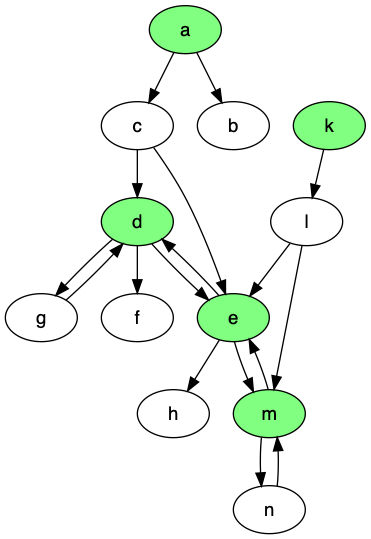

In [6]:
# PW-1
t_pw_rels_dfs, _ = pw_slicer(pw_rels_dfs, None, pws_to_use=[1])
draw(visualize_game(t_pw_rels_dfs['move_2'], t_pw_rels_dfs['win_1'], None, None))

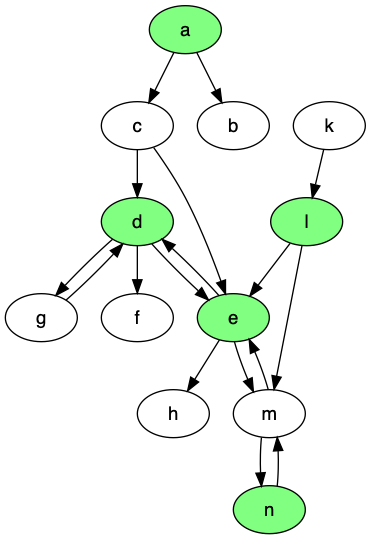

In [7]:
# PW-2
t_pw_rels_dfs, _ = pw_slicer(pw_rels_dfs, None, pws_to_use=[2])
draw(visualize_game(t_pw_rels_dfs['move_2'], t_pw_rels_dfs['win_1'], 
                    pd.DataFrame(columns=['x1']), None))

#### Now we use the WFS mode in dlv to get a 3 valued model for this problem.

In [8]:
dlv_soln, meta_data = run_dlv(dlv_rules=dlv_rules, wfs_mode=True)
print('\n'.join(dlv_soln))

True: {move(a,b), move(a,c), move(c,d), move(c,e), move(k,l), move(l,e), move(l,m), move(d,e), move(d,f), move(d,g), move(e,d), move(e,m), move(e,h), move(m,e), move(m,n), move(g,d), move(n,m), win(a), win(d), win(e)}
Undefined: {win(l), win(k), win(m), win(n)}


So 'a', 'd' and 'e' are winning states in all cases.

Loading this 3 valued model into PWE

In [9]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=dlv_soln, meta_data=meta_data, reasoner='dlv')

In [10]:
# Parsed Relations
list(map(lambda x: x.__dict__, rel_schemas))

[{'relation_name': 'win_1', 'arity': 1, 'r_id': 0, 'meta_data': {}},
 {'relation_name': 'move_2', 'arity': 2, 'r_id': 1, 'meta_data': {}}]

In [11]:
pw_rels_dfs.keys()

dict_keys(['win_1', 'move_2'])

In [12]:
pw_rels_dfs['win_1']

,wfs_status,x1
0,true,a
1,true,d
2,true,e
3,undefined,l
4,undefined,k
5,undefined,m
6,undefined,n


In [13]:
pw_rels_dfs['move_2']

,wfs_status,x1,x2
0,true,a,b
1,true,a,c
2,true,c,d
3,true,c,e
4,true,k,l
5,true,l,e
6,true,l,m
7,true,d,e
8,true,d,f
9,true,d,g


#### Now we can export these back as ASP for further analysis

In [14]:
t_pw_rels_def, _, _ = rel_slicer(pw_rels_dfs, None, None, rels_to_use=['move_2', 'win_1'])
wf_model_facts = PWEExport.export_wfs_model_as_asp_facts(dfs=t_pw_rels_def)
wf_model_facts

['win(true,a).',
 'win(true,d).',
 'win(true,e).',
 'win(undefined,l).',
 'win(undefined,k).',
 'win(undefined,m).',
 'win(undefined,n).',
 'move(true,a,b).',
 'move(true,a,c).',
 'move(true,c,d).',
 'move(true,c,e).',
 'move(true,k,l).',
 'move(true,l,e).',
 'move(true,l,m).',
 'move(true,d,e).',
 'move(true,d,f).',
 'move(true,d,g).',
 'move(true,e,d).',
 'move(true,e,m).',
 'move(true,e,h).',
 'move(true,m,e).',
 'move(true,m,n).',
 'move(true,g,d).',
 'move(true,n,m).']

##### New rules to help us in our analysis of the 4 states.

In [15]:
new_rules = [
    'move(X,Y) :- move(true,X,Y).',
    'pos(X) :- move(X, _).',
    'pos(X) :- move(_, X).',
    'won(X) :- win(true, X).',
    'drawn(X) :- win(undefined, X).',
    'lost(X) :- pos(X), not won(X), not drawn(X).',
]

#### Resulting set of rules

In [16]:
print('\n'.join(wf_model_facts+new_rules))

win(true,a).
win(true,d).
win(true,e).
win(undefined,l).
win(undefined,k).
win(undefined,m).
win(undefined,n).
move(true,a,b).
move(true,a,c).
move(true,c,d).
move(true,c,e).
move(true,k,l).
move(true,l,e).
move(true,l,m).
move(true,d,e).
move(true,d,f).
move(true,d,g).
move(true,e,d).
move(true,e,m).
move(true,e,h).
move(true,m,e).
move(true,m,n).
move(true,g,d).
move(true,n,m).
move(X,Y) :- move(true,X,Y).
pos(X) :- move(X, _).
pos(X) :- move(_, X).
won(X) :- win(true, X).
drawn(X) :- win(undefined, X).
lost(X) :- pos(X), not won(X), not drawn(X).


Let's switch it up and run this in clingo instead of dlv (flexible!)

In [17]:
clingo_soln, meta_data = run_clingo(clingo_rules=wf_model_facts+new_rules)
print('\n'.join(clingo_soln))

Answer: 1
move(true,a,b) move(true,a,c) move(true,c,d) move(true,c,e) move(true,k,l) move(true,l,e) move(true,l,m) move(true,d,e) move(true,d,f) move(true,d,g) move(true,e,d) move(true,e,m) move(true,e,h) move(true,m,e) move(true,m,n) move(true,g,d) move(true,n,m) move(a,b) move(a,c) move(c,d) move(c,e) move(k,l) move(l,e) move(l,m) move(d,e) move(d,f) move(d,g) move(e,d) move(e,m) move(e,h) move(m,e) move(m,n) move(g,d) move(n,m) pos(a) pos(c) pos(k) pos(l) pos(d) pos(e) pos(m) pos(g) pos(n) pos(b) pos(f) pos(h) win(true,a) win(true,d) win(true,e) win(undefined,l) win(undefined,k) win(undefined,m) win(undefined,n) won(a) won(d) won(e) drawn(l) drawn(k) drawn(m) drawn(n) lost(c) lost(g) lost(b) lost(f) lost(h)
SATISFIABLE

Models       : 1
Calls        : 1
Time         : 0.009s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)
CPU Time     : 0.003s


Same loading steps as above

In [18]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 1


In [19]:
pw_rels_dfs.keys()

dict_keys(['move_3', 'move_2', 'pos_1', 'win_2', 'won_1', 'drawn_1', 'lost_1'])

In [20]:
pw_rels_dfs['pos_1']

,pw,x1
0,1,a
1,1,c
2,1,k
3,1,l
4,1,d
5,1,e
6,1,m
7,1,g
8,1,n
9,1,b


In [21]:
pw_rels_dfs['move_2']

,pw,x1,x2
0,1,a,b
1,1,a,c
2,1,c,d
3,1,c,e
4,1,k,l
5,1,l,e
6,1,l,m
7,1,d,e
8,1,d,f
9,1,d,g


In [22]:
pw_rels_dfs['won_1']

,pw,x1
0,1,a
1,1,d
2,1,e


In [23]:
pw_rels_dfs['drawn_1']

,pw,x1
0,1,l
1,1,k
2,1,m
3,1,n


In [24]:
pw_rels_dfs['lost_1']

,pw,x1
0,1,c
1,1,g
2,1,b
3,1,f
4,1,h


#### Visualizing this solution

Legend: <span style="color:#d3c908">drawn</span>, <span style="color:#FF8080">lost</span>, <span style="color:#80FF80">won</span>

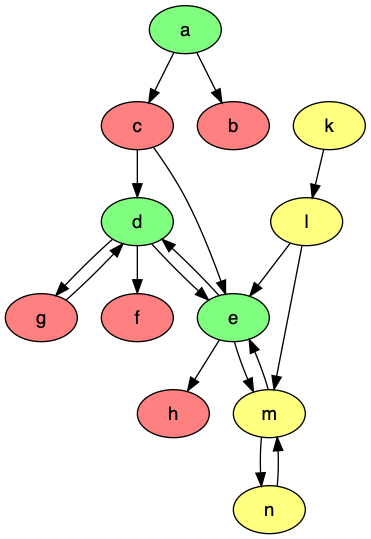

In [25]:
G = visualize_game(pw_rels_dfs['move_2'], pw_rels_dfs['won_1'], pw_rels_dfs['drawn_1'], pw_rels_dfs['lost_1'])
draw(G)

In [26]:
# To save the above visualization
# for f in ['png', 'svg', 'pdf', 'dot']:
#     draw(G, format=f, filename='game_states_wfs_complex.{}'.format(f), show='none')